✅ Data loaded: (500, 9)


,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


✅ After preprocessing: (500, 9)


,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,NaN,NaN,4.085946e+04,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,NaN,NaN,1.080000e+00,0.000,-0.004,0.009,9.525810e+04,1.300442e+08,2022-03-16
2,NaN,NaN,7.960000e+00,0.017,0.008,0.015,1.069360e+06,1.302007e+08,2022-03-16
3,NaN,NaN,2.949200e-01,0.023,0.010,0.045,3.041720e+03,1.327759e+08,2022-03-16
4,NaN,NaN,3.051000e-09,0.012,-0.005,-0.041,1.894020e+05,1.329136e+08,2022-03-16


✅ Features engineered. Columns: 18


,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date,market_cap,price_ma_7,price_ma_30,volatility_7,volatility_30,liquidity_ratio,liq_ratio_lag_1,liq_ratio_diff_1,liquidity
0,0.0,0.0,4.085946e+04,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16,1.446047e+15,40859.460000,40859.460000,0.000000,0.000000,2.447414e-05,0.000024,0.000000e+00,2.447414e-05
1,0.0,0.0,1.080000e+00,0.000,-0.004,0.009,9.525810e+04,1.300442e+08,2022-03-16,1.028787e+05,20430.270000,20430.270000,28891.237566,28891.237566,9.259259e-01,0.000024,9.259015e-01,4.629752e-01
2,0.0,0.0,7.960000e+00,0.017,0.008,0.015,1.069360e+06,1.302007e+08,2022-03-16,8.512106e+06,13622.833333,13622.833333,23587.610858,23587.610858,1.256281e-01,0.925926,-8.002978e-01,3.505262e-01
3,0.0,0.0,2.949200e-01,0.023,0.010,0.045,3.041720e+03,1.327759e+08,2022-03-16,8.970641e+02,10217.198730,10217.198730,20428.174470,20428.174470,3.390750e+00,0.125628,3.265122e+00,1.480768e+00
4,0.0,0.0,3.051000e-09,0.012,-0.005,-0.041,1.894020e+05,1.329136e+08,2022-03-16,5.778655e-04,8173.758984,8173.758984,18271.862634,18271.862634,3.277608e+08,3.390750,3.277608e+08,1.092536e+08


✅ Model trained successfully!
MAE: 2216189.330723, RMSE: 163008922545662.031250, R²: 0.5863


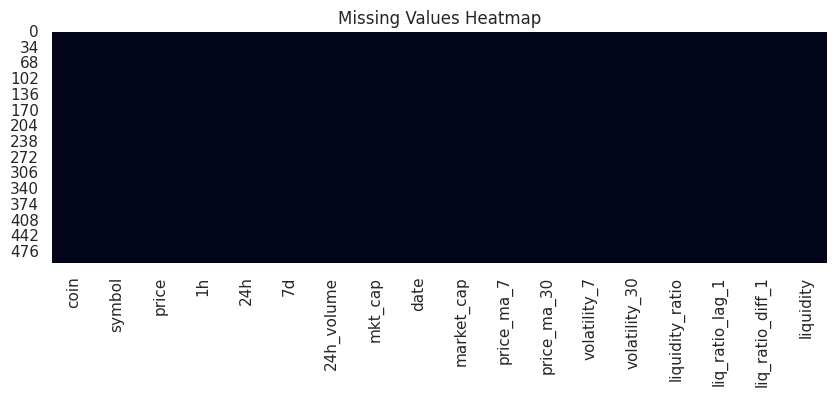

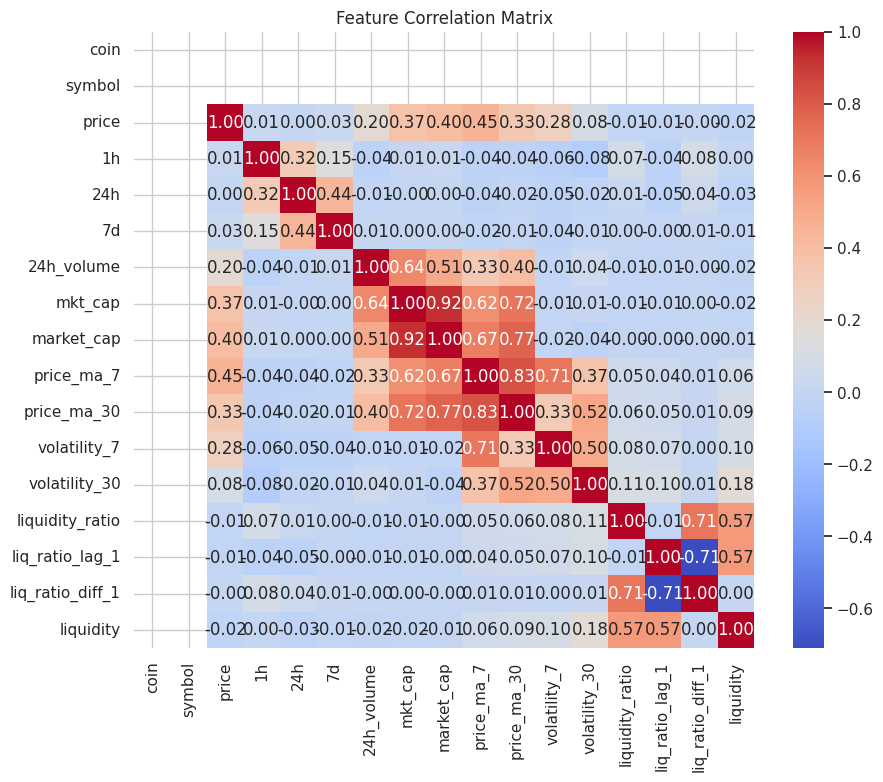

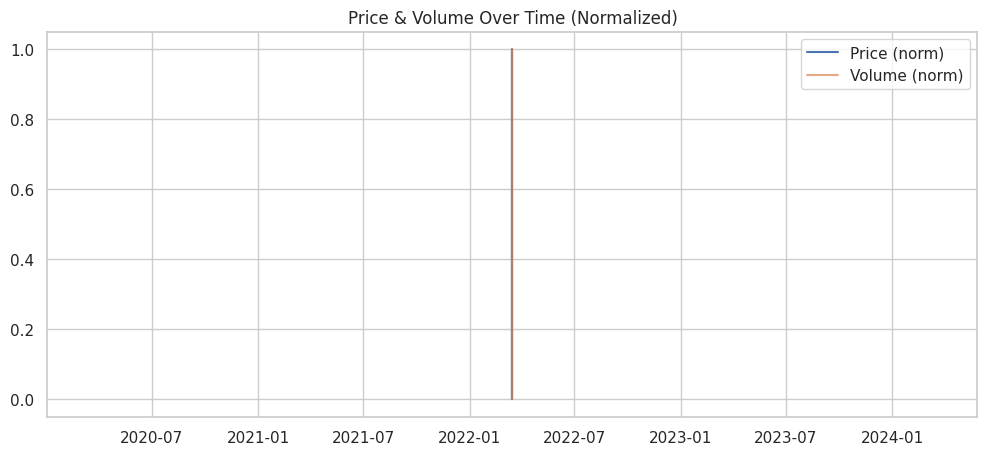

In [ ]:
# ======================================
# 🔹 CRYPTO LIQUIDITY PREDICTION PROJECT
# ======================================

# ✅ Step 1. Install dependencies
!pip install pandas numpy scikit-learn matplotlib seaborn joblib streamlit xgboost --quiet

# ✅ Step 2. Import libraries
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib, warnings, os
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ============================================================
# Step 3. Load dataset (upload your CSV if needed)
# ============================================================
# ⬆️ Upload your dataset in the left sidebar: Files → Upload → coin_gecko_2022-03-16.csv
# then set its path below
DATA_PATH = "/content/coin_gecko_2022-03-16.csv"

df = pd.read_csv(DATA_PATH)
print("✅ Data loaded:", df.shape)
display(df.head())

# ============================================================
# Step 4. Preprocessing
# ============================================================
def preprocess(df):
    df = df.copy()
    # detect date column
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
    if date_cols:
        df['date'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        # Create a date range if no date column is found
        df['date'] = pd.to_datetime(pd.date_range(end=pd.Timestamp.today(), periods=len(df), freq='D'))

    df = df.sort_values('date').reset_index(drop=True)
    df = df.fillna(method='ffill').fillna(method='bfill')

    for col in df.columns:
        # Convert object type columns to numeric, coercing errors
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop columns that couldn't be converted to numeric and are not date
    non_numeric_cols = df.select_dtypes(exclude=[np.number, np.datetime64]).columns.tolist()
    if non_numeric_cols:
        print(f"Dropping non-numeric columns: {non_numeric_cols}")
        df = df.drop(columns=non_numeric_cols)

    return df

df = preprocess(df)
print("✅ After preprocessing:", df.shape)
display(df.head())


# ============================================================
# Step 5. Feature Engineering
# ============================================================
def feature_engineer(df):
    df = df.copy()
    # identify price, volume, market cap columns
    # Ensure price_col is always a valid column name, defaulting to the first numeric column if no price-like column exists
    price_col = next((c for c in df.columns if 'price' in c.lower() and df[c].dtype in [np.number]), None)
    if price_col is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if numeric_cols.empty:
             raise ValueError("No numeric columns found to use as price.")
        price_col = numeric_cols[0]


    vol_col   = next((c for c in df.columns if 'volume' in c.lower() and df[c].dtype in [np.number]), None)
    mc_col    = next((c for c in df.columns if 'market' in c.lower() and 'cap' in c.lower() and df[c].dtype in [np.number]), None)

    if vol_col is None: df['volume'] = df[price_col]*0.1; vol_col='volume'
    if mc_col is None: df['market_cap'] = df[price_col]*df[vol_col]; mc_col='market_cap'

    for c in [price_col, vol_col, mc_col]:
        # Ensure these columns are numeric, coercing errors and filling NaNs
        if c in df.columns: # Check if column exists after dropping non-numeric ones
             df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)


    df['price_ma_7'] = df[price_col].rolling(7,1).mean()
    df['price_ma_30'] = df[price_col].rolling(30,1).mean()
    df['volatility_7'] = df[price_col].rolling(7,1).std().fillna(0)
    df['volatility_30'] = df[price_col].rolling(30,1).std().fillna(0)
    # Add a small epsilon to the denominator to avoid division by zero
    df['liquidity_ratio'] = df[vol_col]/(df[mc_col].replace(0,np.nan)+1e-9)
    df['liquidity_ratio'] = df['liquidity_ratio'].fillna(0)
    df['liq_ratio_lag_1'] = df['liquidity_ratio'].shift(1).fillna(method='bfill')
    df['liq_ratio_diff_1'] = df['liquidity_ratio'] - df['liq_ratio_lag_1']
    df['liquidity'] = df['liquidity_ratio'].rolling(3,1).mean()
    df = df.fillna(0)
    return df

df = feature_engineer(df)
print("✅ Features engineered. Columns:", df.shape[1])
display(df.head())

# ============================================================
# Step 6. Train/Test Split and Model Training
# ============================================================
features = ['price_ma_7','price_ma_30','volatility_7','volatility_30',
            'liquidity_ratio','liq_ratio_lag_1','liq_ratio_diff_1']
# Ensure all feature columns exist and are numeric before dropping NaNs
features_exist = [f for f in features if f in df.columns and df[f].dtype in [np.number]]
if len(features_exist) != len(features):
    missing_features = list(set(features) - set(features_exist))
    print(f"Warning: Missing or non-numeric feature columns: {missing_features}. These will be excluded.")
    features = features_exist

df = df.dropna(subset=['liquidity'] + features) # Ensure 'liquidity' is also numeric


split_idx = int(len(df)*0.8)
X_train, X_test = df[features].iloc[:split_idx], df[features].iloc[split_idx:]
y_train, y_test = df['liquidity'].iloc[:split_idx], df['liquidity'].iloc[split_idx:]

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) # Removed squared=False
r2 = r2_score(y_test, y_pred)

print(f"✅ Model trained successfully!")
print(f"MAE: {mae:.6f}, RMSE: {rmse:.6f}, R²: {r2:.4f}")

# ============================================================
# Step 7. Visualizations (EDA)
# ============================================================

# Missing values heatmap
plt.figure(figsize=(10,3))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Correlation matrix
plt.figure(figsize=(10,8))
# Select only numeric columns for correlation calculation
df_numeric = df.select_dtypes(include=[np.number])
sns.heatmap(df_numeric.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Price & Volume trends
plt.figure(figsize=(12,5))
price_col = next((c for c in df.columns if 'price' in c.lower()), df.select_dtypes(include=[np.number]).columns[0])
vol_col   = next((c for c in df.columns if 'volume' in c.lower()), None)
def norm(s): return (s - s.min())/(s.max()-s.min()+1e-9)

# Ensure price_col and vol_col exist and are numeric before plotting
if price_col in df.columns and df[price_col].dtype in [np.number]:
    plt.plot(df['date'], norm(df[price_col]), label='Price (norm)')
else:
    print(f"Warning: Price column '{price_col}' not found or is not numeric. Skipping price trend plot.")

if vol_col in df.columns and df[vol_col].dtype in [np.number]:
    plt.plot(df['date'], norm(df[vol_col]), label='Volume (norm)', alpha=0.7)
else:
     print(f"Warning: Volume column '{vol_col}' not found or is not numeric. Skipping volume trend plot.")

plt.legend(); plt.title("Price & Volume Over Time (Normalized)")
plt.show()

# Liquidity ratio distribution
plt.figure(figsize=(6,4))
sns.histplot(df['liquidity_ratio'], kde=True)
plt.title("Liquidity Ratio Distribution")
plt.show()

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Liquidity")
plt.ylabel("Predicted Liquidity")
plt.title("Actual vs Predicted Liquidity")
plt.show()

# ============================================================
# Step 8. Save Model (optional)
# ============================================================
os.makedirs("/content/model", exist_ok=True)
joblib.dump(model, "/content/model/liquidity_rf.pkl")
print("💾 Model saved to /content/model/liquidity_rf.pkl")

# ============================================================
# Step 9. Predict Example
# ============================================================
sample = X_test.iloc[-1].values.reshape(1,-1)
pred = model.predict(sample)[0]
print("🔮 Sample prediction:", pred)


✅ Using DataFrame from previous cell: 500 rows × 9 columns



,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


🔹 Missing values per column after feature engineering:

coin          0
symbol        0
price         0
1h            3
24h           3
7d            3
24h_volume    3
mkt_cap       0
date          0
dtype: int64

🔹 Data types after feature engineering:

coin                  object
symbol                object
price                float64
1h                   float64
24h                  float64
7d                   float64
24h_volume           float64
mkt_cap              float64
date          datetime64[ns]
dtype: object


,count,mean,min,25%,50%,75%,max,std
price,500.0,652.785125,0.0,0.190462,1.085,6.925,41217.27,4578.529058
1h,497.0,0.018746,-0.039,0.011,0.018,0.026,0.086,0.013867
24h,497.0,0.028849,-0.141,0.004,0.021,0.04,0.573,0.058065
7d,497.0,0.039016,-0.547,-0.02,0.006,0.049,2.935,0.203688
24h_volume,497.0,327664390.959376,0.0,1838591.0,8581305.0,40756551.0,57934969077.0,3182263989.682093
mkt_cap,500.0,3722677118.29,65770433.0,114639094.0,208320750.5,584564159.0,770991461396.0,37843487867.082863
date,500,2022-03-16 00:00:00,2022-03-16 00:00:00,2022-03-16 00:00:00,2022-03-16 00:00:00,2022-03-16 00:00:00,2022-03-16 00:00:00,NaN


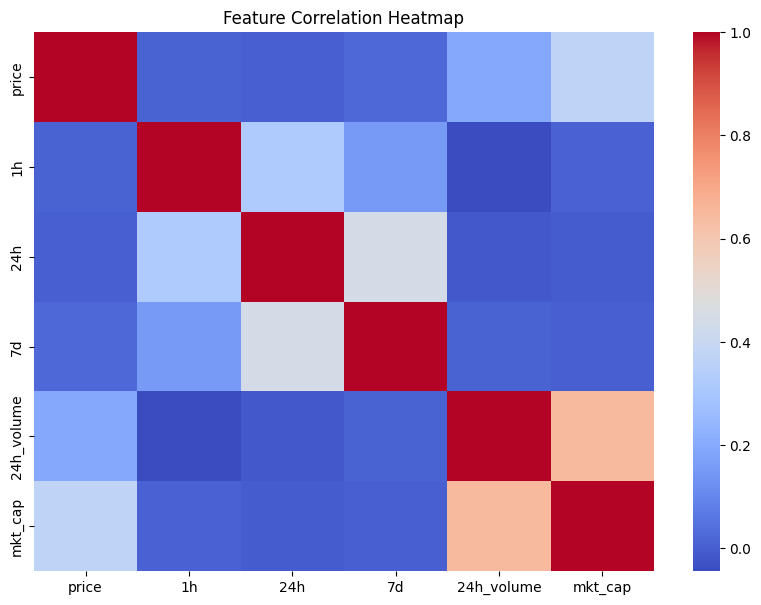

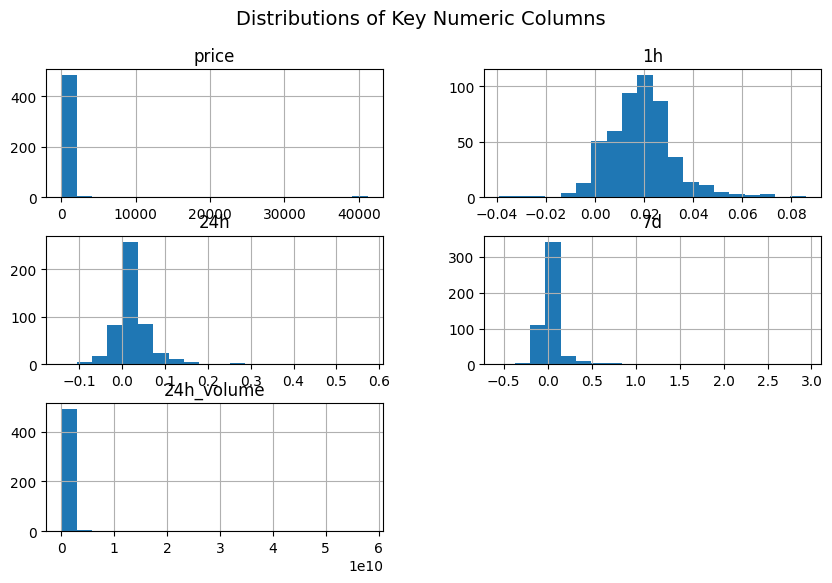


✅ EDA completed. All plots displayed above.


In [2]:
# ==========================================================
# 🧠  Crypto Liquidity Prediction - EDA (No PDF)
# ==========================================================

# 1️⃣ Install dependencies
!pip install pandas numpy matplotlib seaborn --quiet

# 2️⃣ Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files # No longer needed
import os

# 3️⃣ Upload your dataset (processed.csv or cleaned.csv) - No longer needed
# print("📂 Please upload your dataset (e.g., data/processed.csv)...")
# uploaded = files.upload()
# csv_path = list(uploaded.keys())[0]
# print(f"✅ File uploaded: {csv_path}")

# 4️⃣ Load dataset - No longer needed, using df from previous cell
# df = pd.read_csv(csv_path)
print(f"\n✅ Using DataFrame from previous cell: {df.shape[0]} rows × {df.shape[1]} columns\n")
display(df.head())

# 5️⃣ Basic info
print("🔹 Missing values per column after feature engineering:\n")
print(df.isna().sum())
print("\n🔹 Data types after feature engineering:\n")
print(df.dtypes)

# 6️⃣ Descriptive statistics
display(df.describe().T)

# 7️⃣ Correlation heatmap
# Select only numeric columns for correlation calculation
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# 8️⃣ Distributions of key numeric columns
# Select numeric columns, excluding the date if it was converted to numeric
num_cols = df.select_dtypes(include=[np.number]).columns
# Exclude columns with very large values that might distort the plot
num_cols = [col for col in num_cols if df[col].max() < 1e12] # Adjust threshold as needed
if len(num_cols) > 5:
    num_cols = num_cols[:5] # Limit to first 5 if there are many
elif len(num_cols) == 0:
    print("No suitable numeric columns for distribution plots.")

if num_cols:
    df[num_cols].hist(bins=20, figsize=(10,6))
    plt.suptitle("Distributions of Key Numeric Columns", fontsize=14)
    plt.show()
else:
    print("No numeric columns available for distribution plots.")


# 9️⃣ Liquidity trend over time (if date column present)
if 'date' in df.columns:
    # Ensure date column is in datetime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Drop rows where date conversion failed
    df_plot = df.dropna(subset=['date']).copy()
    # Ensure liquidity column exists and is numeric
    if 'liquidity' in df_plot.columns and df_plot['liquidity'].dtype in [np.number]:
        plt.figure(figsize=(12,5))
        plt.plot(df_plot['date'], df_plot['liquidity'], color='blue')
        plt.title("Liquidity Trend Over Time")
        plt.xlabel("Date"); plt.ylabel("Liquidity")
        plt.grid(True)
        plt.show()
    else:
        print("Warning: 'liquidity' column not found or is not numeric. Skipping liquidity trend plot.")
else:
    print("Warning: 'date' column not found. Skipping liquidity trend plot.")


# 🔟 Price vs Liquidity scatter
price_col = next((c for c in df.columns if 'price' in c.lower()), None)
if price_col and 'liquidity' in df.columns:
    # Ensure both columns are numeric before plotting
    if df[price_col].dtype in [np.number] and df['liquidity'].dtype in [np.number]:
        plt.figure(figsize=(7,5))
        sns.scatterplot(x=df[price_col], y=df['liquidity'], alpha=0.6)
        plt.title(f"{price_col} vs Liquidity")
        plt.xlabel("Price")
        plt.ylabel("Liquidity")
        plt.show()
    else:
        print(f"Warning: '{price_col}' or 'liquidity' column is not numeric. Skipping Price vs Liquidity scatter plot.")
else:
    print(f"Warning: '{price_col}' or 'liquidity' column not found. Skipping Price vs Liquidity scatter plot.")


# 11️⃣ Volatility vs Liquidity
if 'volatility_7' in df.columns and 'liquidity' in df.columns:
    # Ensure both columns are numeric before plotting
    if df['volatility_7'].dtype in [np.number] and df['liquidity'].dtype in [np.number]:
        plt.figure(figsize=(7,5))
        sns.scatterplot(x=df['volatility_7'], y=df['liquidity'], alpha=0.6, color='orange')
        plt.title("Volatility (7-day) vs Liquidity")
        plt.xlabel("Volatility_7")
        plt.ylabel("Liquidity")
        plt.show()
    else:
         print("Warning: 'volatility_7' or 'liquidity' column is not numeric. Skipping Volatility vs Liquidity scatter plot.")
else:
    print("Warning: 'volatility_7' or 'liquidity' column not found. Skipping Volatility vs Liquidity scatter plot.")


print("\n✅ EDA completed. All plots displayed above.")